In [164]:
import requests
import lxml.html as lh
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

#print(page.text)

In [165]:
#Generate league name csv
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
league_name_arr = np.zeros((len(leagues), 10)).astype(str)

for i in range(len(leagues)):
    league_name_arr[i,:] = leagues[i]  

In [166]:
leagues = ['top14', 'prod2', 'federale1', 'englandpremiership', 'pro14', 'englishchampionship', 'superrugby', 'itmcup', 'curriecup', 'urbatop14']
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = leagues[i], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        count = 0
        if(len(list(soup.find_all('tr'))) <50 ):
            league_name_arr[i,j] = 'error'

    


In [167]:
x_error = []
y_error = []
count = 0
for i in range(league_name_arr.shape[0]):
    for j in range(league_name_arr.shape[1]):
        if(league_name_arr[i,j] == 'error'):
            print(leagues[i], years[j])
            print(i,j)
            x_error.append(i)
            y_error.append(j)
            count += 1
            print(count)

federale1 2013
2 2
1
englandpremiership 2011
3 0
2
englandpremiership 2012
3 1
3
englandpremiership 2013
3 2
4
englandpremiership 2014
3 3
5
englandpremiership 2015
3 4
6
englandpremiership 2016
3 5
7
englandpremiership 2017
3 6
8
englandpremiership 2018
3 7
9
pro14 2011
4 0
10
pro14 2012
4 1
11
pro14 2013
4 2
12
pro14 2014
4 3
13
pro14 2015
4 4
14
pro14 2016
4 5
15
pro14 2017
4 6
16
pro14 2018
4 7
17
englishchampionship 2016
5 5
18
englishchampionship 2017
5 6
19
englishchampionship 2018
5 7
20
englishchampionship 2019
5 8
21
englishchampionship 2020
5 9
22
itmcup 2019
7 8
23
itmcup 2020
7 9
24
urbatop14 2016
9 5
25
urbatop14 2017
9 6
26
urbatop14 2018
9 7
27
urbatop14 2019
9 8
28
urbatop14 2020
9 9
29


In [168]:
print(x_error)

[2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 7, 7, 9, 9, 9, 9, 9]


In [179]:
error_fixes = ['federale1', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership', 'avivapremiership','avivapremiership', 'avivapremiership', 'premiershiprugby', 'rabodirect12', 'rabodirect12', 'rabodirect12', 'guinesspro12', 'guinesspro12', 'pro12rugby', 'guinesspro14', 'guinesspro14', 'angleterred21', 'angleterred21', 'englandchampionship', 'englandd1', 'englandd1', 'mitre10cup', 'mitre10cup', 'urbatop12', 'urbatop12', 'urbatop12', 'error', 'urbatop12']
for i in range(len(error_fixes)):
    league_name_arr[x_error[i], y_error[i]] = error_fixes[i]


In [170]:
print(league_name_arr[:,:])

[['top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14' 'top14'
  'top14']
 ['prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2' 'prod2'
  'prod2']
 ['federale1' 'federale1' 'federale1' 'federale1' 'federale1' 'federale1'
  'federale1' 'federale1' 'federale1' 'federale1']
 ['avivapremiership' 'avivapremiership' 'avivapremiership'
  'avivapremiership' 'avivapremiership' 'avivapremiership'
  'avivapremiership' 'premiershiprugby' 'englandpremiership'
  'englandpremiership']
 ['rabodirect12' 'rabodirect12' 'rabodirect12' 'guinesspro12'
  'guinesspro12' 'pro12rugby' 'guinesspro14' 'guinesspro14' 'pro14'
  'pro14']
 ['englishchampionship' 'englishchampionship' 'englishchampionship'
  'englishchampionship' 'englishchampionship' 'angleterred21'
  'angleterred21' 'englandchampionship' 'englandd1' 'englandd1']
 ['superrugby' 'superrugby' 'superrugby' 'superrugby' 'superrugby'
  'superrugby' 'superrugby' 'superrugby' 'superrugby' 'superrugby']
 ['itmcup' 'itmcup' 'itmcup' 'i

In [180]:
from bs4 import BeautifulSoup
leagues_10yr_stats = {}
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
result_ind = [1,0,7,6,13,12,19,18]
result_stat = ['tries_avg', 'tries_nb', 'conv_avg', 'conv_nb', 'pen_avg', 'pen_nb', 'dg_avg', 'dg_nb']
for i in range(len(leagues)):
    league_stats = {'tries_avg': [], 'tries_nb': [], 'conv_avg': [], 'conv_nb': [], 'pen_avg': [], 'pen_nb': [], 'dg_avg': [], 'dg_nb': []}
    for j in range(len(years)):
        URL = 'https://www.itsrugby.co.uk/stats-{league}-{year}.html'.format(league = league_name_arr[i,j], year = years[j])
        #rint(URL)
        page = requests.get(URL)
        soup = BeautifulSoup(page.text, "html.parser")
        result_array = []
        count = 0
        for result in soup.find_all('tr'):
            #print(len(list(result)))
            for result2 in result.find_all('td', attrs = {"align": "center", "id": "noir"}):
                #print(len(list(result2.contents)))
                if (count>7 and count <32):
                    #print(result2.contents)
                    try:
                        result_array.append(float(result2.contents[0]))
                    except: 
                        result_array.append(np.nan)
                count+=1
        print(result_array)
        for k in range(8):
            try:
                league_stats[result_stat[k]].append(result_array[result_ind[k]])
            except IndexError: 
                league_stats[result_stat[k]].append(np.nan)
                print(URL)
    leagues_10yr_stats[leagues[i]] = league_stats

[559.0, 3.07, 352.0, 1.93, 207.0, 1.13, 449.0, 2.46, 283.0, 1.55, 166.0, 0.91, 1157.0, 6.35, 672.0, 3.69, 485.0, 2.66, 60.0, 0.32, 30.0, 0.16, 30.0, 0.16]
[653.0, 3.58, 417.0, 2.29, 236.0, 1.29, 518.0, 2.84, 341.0, 1.87, 177.0, 0.97, 1148.0, 6.3, 660.0, 3.62, 488.0, 2.68, 59.0, 0.32, 29.0, 0.15, 30.0, 0.16]
[600.0, 3.29, 417.0, 2.29, 183.0, 1.0, 455.0, 2.5, 318.0, 1.74, 137.0, 0.75, 1111.0, 6.1, 621.0, 3.41, 490.0, 2.69, 52.0, 0.28, 27.0, 0.14, 25.0, 0.13]
[724.0, 3.97, 479.0, 2.63, 245.0, 1.34, 540.0, 2.96, 352.0, 1.93, 188.0, 1.03, 1053.0, 5.78, 562.0, 3.08, 491.0, 2.69, 42.0, 0.23, 15.0, 0.08, 27.0, 0.14]
[824.0, 4.52, 517.0, 2.84, 307.0, 1.68, 617.0, 3.39, 384.0, 2.1, 233.0, 1.28, 976.0, 5.36, 526.0, 2.89, 450.0, 2.47, 19.0, 0.1, 9.0, 0.04, 10.0, 0.05]
[853.0, 4.68, 528.0, 2.9, 325.0, 1.78, 671.0, 3.68, 425.0, 2.33, 246.0, 1.35, 1026.0, 5.63, 571.0, 3.13, 455.0, 2.5, 24.0, 0.13, 17.0, 0.09, 7.0, 0.03]
[973.0, 5.34, 600.0, 3.29, 373.0, 2.04, 754.0, 4.14, 480.0, 2.63, 274.0, 1.5, 787

[779.0, 5.64, 441.0, 3.19, 338.0, 2.44, 540.0, 3.91, 310.0, 2.24, 230.0, 1.66, 516.0, 3.73, 249.0, 1.8, 267.0, 1.93, 4.0, 0.02, 2.0, 0.01, 2.0, 0.01]
[784.0, 5.93, 425.0, 3.21, 359.0, 2.71, 520.0, 3.93, 289.0, 2.18, 231.0, 1.75, 411.0, 3.11, 198.0, 1.5, 213.0, 1.61, 7.0, 0.05, 5.0, 0.03, 2.0, 0.01]
[819.0, 6.2, 432.0, 3.27, 387.0, 2.93, 573.0, 4.34, 313.0, 2.37, 260.0, 1.96, 372.0, 2.81, 193.0, 1.46, 179.0, 1.35, 11.0, 0.08, 5.0, 0.03, 6.0, 0.04]
[787.0, 6.39, 404.0, 3.28, 383.0, 3.11, 536.0, 4.35, 281.0, 2.28, 255.0, 2.07, 326.0, 2.65, 170.0, 1.38, 156.0, 1.26, 12.0, 0.09, 4.0, 0.03, 8.0, 0.06]
[931.0, 7.05, 493.0, 3.73, 438.0, 3.31, 675.0, 5.11, 368.0, 2.78, 307.0, 2.32, 350.0, 2.65, 186.0, 1.4, 164.0, 1.24, 4.0, 0.03, 3.0, 0.02, 1.0, 0.0]
[917.0, 6.94, 481.0, 3.64, 436.0, 3.3, 645.0, 4.88, 338.0, 2.56, 307.0, 2.32, 253.0, 1.91, 139.0, 1.05, 114.0, 0.86, 5.0, 0.03, 2.0, 0.01, 3.0, 0.02]
[525.0, 3.97, 282.0, 2.13, 243.0, 1.84, 367.0, 2.78, 199.0, 1.5, 168.0, 1.27, 206.0, 1.56, 108.0, 

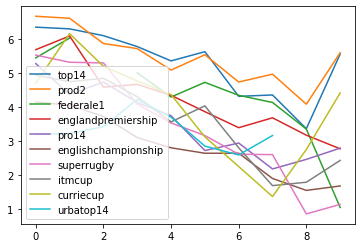

In [185]:
#print(leagues_10yr_stats)
for key, value in leagues_10yr_stats.items():
    plt.plot(value['pen_avg'])
#plt.labels = leagues_10yr_stats.keys()
plt.legend(leagues_10yr_stats.keys())

In [174]:
print(type(np.nan))

<class 'float'>
